# Churn Analytics
## Time to Churn

Customer churn analytics is used to predict the point in time when a customer will no longer be considered active. A customer may churn by withdrawing from service or by choosing to not renew their subscription. Although each business is different, sometimes it is easier to retain existing customers than to acquire new ones. For those businesses, it is important to not only predict which customers are likely to churn but also which customers are likely to stay active. Some businesses have a loyal customer population and will not leave until many years down the road, so in the short-term they would always be active. This scenario can be modeled as a cure rate survival (crs) analysis problem. The event of interest is the customer leaving, the time-to-event is considered the time difference from the acquisition of a new customer, and the cured population is considered those who never leave the company.

## Imports 

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.preprocessing import OneHotEncoder
from apd_crs.survival_analysis import SurvivalAnalysis
from apd_crs.datasets import load_telco

## Using the SurvivalAnalysis class: Get labels

In [2]:
#Instantiate the SurvivalAnalysis class and get labels
model = SurvivalAnalysis()
cure_label = model.get_cure_label()
noncure_label = model.get_non_cure_label()
censor_label = model.get_censor_label()

## The churn dataset

We investiage on the Telco dataset from Kaggle.com https://www.kaggle.com/blastchar/telco-customer-churn

In [3]:
dataset = load_telco() #load the data 

In [4]:
data, labels, times = dataset.data, dataset.target, dataset.target_times
#Load the covariates, labels (censored or not), and times

## Data Preprocessing


In [5]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') #covert string to numeric
data.dropna(inplace=True) #Drop rows with nulls 
data.drop(columns='customerID', inplace=True) #Drop uniformative column

In [6]:
#Convert object columns to categorical so we can us sksurv one-hot encoder
for col in data.columns: 
    if col not in ['MonthlyCharges', 'TotalCharges', 'Churn', 'SeniorCitizen', 'tenure']:
        data[col] = data[col].astype('category')

In [7]:
#Record the index to keep track of dropped rows when aligning with labels and times
idx = data.index

In [8]:
#Test train split: To evaluate test performance we split the data into training and testing data;
#test_size is percentage going to test data
from sklearn.model_selection import train_test_split
training_data, test_data, training_labels, test_labels, training_times, test_times = train_test_split(
    data, labels[idx], times[idx], test_size=0.33)

In [9]:
#Perform one-hot encoding
from sksurv.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
training_data = ohc.fit_transform(training_data)
test_data = ohc.transform(test_data)

/home/nemk/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [10]:
#Scale covariates: Baseline Hazrad estimation is parametric so scaling helps with convergence 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
test_data = scaler.transform(test_data)


In [11]:
#Scale times

training_times = training_times/training_times.max()
test_times = test_times/training_times.max()

## Using the SurvivalAnalysis class: Model Fitting

In [12]:
model.survival_fit(training_data, training_labels, training_times, is_scar=True)
#is_scar=True means we use the selected completely at random assumption to estimate cure probability

/home/nemk/.local/lib/python3.8/site-packages/apd_crs/_survival_func.py:303: RuntimeWarning: Training data should be scaled appropriately to ensure numerical convergence
  warnings.warn("Training data should be scaled appropriately to ensure numerical "
/home/nemk/.local/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


## Evaluating Model Performance

### Danger 



We define the danger associated with an individual having covariate vector $x$ as

$\mbox{Danger}(x) = w_1 (\gamma\cdot x )+ w_2 \log(1-\pi(x))$ 

where $w_1, w_2$ are weights in the unit interval $[0,1]$ which sum to 1,

$\pi(x)$ is the probability of cure, and $\gamma$ is the parameter vector associated with 

the Hazard of the susceptible (non-cured) population. 

The higher the Danger, the riskier the individual. E.g. an individual with 

Danger -1.2 is less at risk than one with Danger 1.0.

Optimal weights can be chosen through cross validation.

### Concordance Index (C-Index)

Two individuals are comparable if one experiences the event before the other. 

A pair of individuals is concordant if the one which "died" first has a higher danger.

C-Index = ratio of concordant pairs to comparable pairs.

Clearly C-index is in $[0,1]$ and the higher the better. 

Random guessing $\Rightarrow$ C-index = 0.5

In [13]:
train_danger =\
(np.dot(training_data, model.gamma_) +\
 np.log(model.predict_cure_proba(training_data,training_labels)[:,1]))

In [14]:
test_danger =\
(np.dot(test_data, model.gamma_) +\
 np.log(model.predict_cure_proba(test_data, test_labels)[:,1]))

## Evaluating Model Performance

### The C-Index

In [15]:
train_score = model.cindex(training_times, training_labels, train_danger) 

print(f"c-index score on train set is {train_score}")

c-index score on train set is 0.8441760372501687


In [16]:
test_score = model.cindex(test_times, test_labels, test_danger) 

print(f"c-index score on test set is {test_score}")

c-index score on test set is 0.8474448313556245


### Overall Risk factors

<AxesSubplot:>

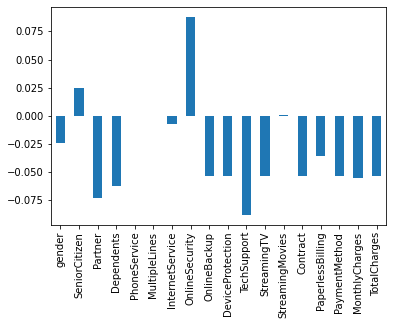

In [17]:
features = [col for col in data.columns if col not in ['broken', 'time_since_repair']]
feats = {col:model.gamma_[i] for (i,col) in enumerate(features)}
feats = pd.Series(feats)
feats.plot.bar()

### Individual Predictions

In [18]:
#Overall survivor function:

#We can plot the overall survival function for e.g. the first five indiduals in the test set.

TIMES = np.arange(1, 93, 0.5)
repeats_array = np.tile(TIMES, (len(test_data), 1))
ovpr = model.predict_overall_survival(test_data, repeats_array, test_labels)

#We can include the corresponding probabilities of cure in a legend
cure_probs =\
[np.around((model.predict_cure_proba(test_data, test_labels)[0:5,0])[i], decimals=2) for i in range(5)]

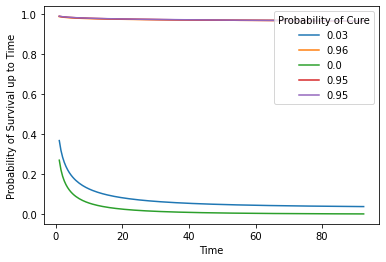

In [19]:
import matplotlib.pyplot as plt
y = ovpr[0:5,:]
x = TIMES
plt.plot(x, y.T, )
plt.xlabel('Time')
plt.ylabel('Probability of Survival up to Time')
plt.legend(labels=cure_probs, loc='upper right', title='Probability of Cure')
plt.show()